In [30]:
import sddpg
import ddpg
from memory import ReplayMemory
import gymnasium as gym
from gymnasium.wrappers import RecordEpisodeStatistics, RecordVideo

import os
import math
import random
import argparse
from tqdm import tqdm
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [31]:
# PARAMETERS
safe = True
training = True
path = 'models/sddpg_cheetah.pt'
file_name = "sddpg_cheetah"

In [32]:
device = 'cpu'

In [34]:
# Hyperparameters
N_EPISODES = 50
BATCH_SIZE = 128
MEMORY_SIZE = 1000000
GAMMA = 0.99
EPS_START = 0.95
EPS_END = 0.05
EPS_DECAY = 100
WEIGHT_DECAY = 0.005
TAU = 1e-3
LR = 1e-4

max_steps = 500

In [35]:
env = gym.make("HalfCheetah-v5", render_mode='rgb_array', max_episode_steps=max_steps)
env = gym.wrappers.NumpyToTorch(env, device=device)
n_actions = env.action_space.shape[0] 
state, _ = env.reset()

n_obs = len(state)

In [36]:
def train(episode, eps_start, eps_end, eps_decay, criterion_critic, agent, memory, env, device=torch.device("cpu")):
    state, info = env.reset()
    state = state.float().unsqueeze(0)

    if isinstance(agent, sddpg.SDDPG):
        x0 = torch.zeros_like(state)
        x0.copy_(state)
        x0 = x0.to(device)
        agent.set_init(x0)

    episode_reward = 0
    max_vel = 0
    while True:
        # Select an action in the current state and
        # add the resulting observations to the
        # memory buffer
        eps = eps_end + (eps_start - eps_end) * math.exp(-1. * episode / eps_decay)

        if random.random()<eps:
            action = torch.tensor(env.action_space.sample()).to(device)

        else:
            action = agent.select_action(state)

        observation, reward, terminated, truncated, _ = env.step(action)
        episode_reward += reward
        reward = torch.tensor([reward], device=device, dtype=torch.float32)
        done = terminated or truncated
        max_vel = max(np.abs(observation[1]), max_vel)
        next_state = None if terminated else observation.float().unsqueeze(0)
        memory.push(state, action.unsqueeze(0), next_state, reward)

        state = next_state
        agent.update(memory, criterion_critic)

        if done:
            return episode_reward, max_vel

In [37]:
def d(x: torch.tensor):
    return (torch.abs(x[:,1])<=np.pi/4).unsqueeze(-1).to(device)

d0 = 50

# Training loop
if safe:
    agent = sddpg.SDDPG(n_obs, n_actions, BATCH_SIZE, GAMMA, TAU, LR, WEIGHT_DECAY,d, d0, state, device=device)
else:
    agent = ddpg.DDPG(n_obs, n_actions, BATCH_SIZE, GAMMA, TAU, LR, WEIGHT_DECAY, device=device)

In [ ]:
if training:
    if path is not None:
        try:
            agent.load(path)
        except:
             print("no model found, continuing")
    criterion_critic = nn.MSELoss()
    memory = ReplayMemory(MEMORY_SIZE)
    losses = []

    for i_episode in (pbar := tqdm(range(N_EPISODES))):
        episode_reward, max_vel = train(i_episode, EPS_START, EPS_END, EPS_DECAY, criterion_critic, agent, memory, env, device=device)
        losses.append(episode_reward)
        pbar.set_postfix({
                    'average last 5 rewards': round(losses[i_episode], 5),
                    'max_vel': round(max_vel.item(), 3),
                    })


    print("Training completed.")
    fig = plt.figure()
    ax  = fig.subplots(1)
    ax.plot(losses)
    ax.set_xlabel("Episode")
    ax.set_ylabel("Reward")
    fig.suptitle("Training Reward over time (DDPG)")
    if os.path.isdir('figures') is False:
                os.mkdir('figures')
    fig.savefig(f"figures/{file_name}_losses.png")
    print("Saving model...")
    agent.save(file_name)
    print("Saved Model Weights!")
else:
    assert path is not None
    agent.load(path)

no model found, continuing


  0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_950954/3307582412.py:29: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  max_vel = max(np.abs(observation[1]), max_vel)
 14%|█▍        | 7/50 [00:50<05:11,  7.25s/it, average last 5 rewards=-190, max_vel=3.55] 

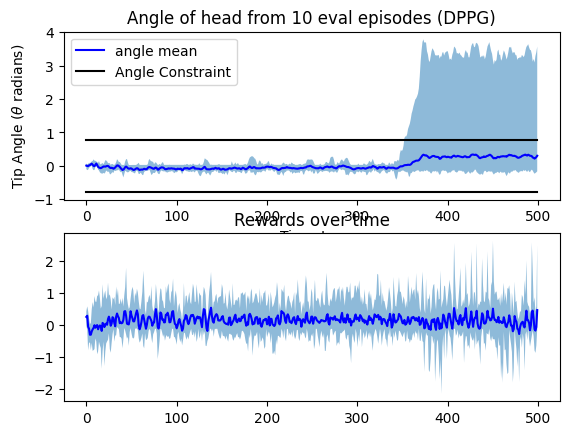

In [ ]:
num_eval_episodes=10
# env = RecordEpisodeStatistics(env, buffer_length=num_eval_episodes)
# env = RecordVideo(env, video_folder="video_renders", name_prefix=f"cheetah_{file_name}", episode_trigger=lambda _: True)
fig = plt.figure()
ax  = fig.subplots(2)
heading = np.zeros((num_eval_episodes, max_steps))
rewards = np.zeros((num_eval_episodes, max_steps))
for episode_num in range(num_eval_episodes):
    obs, _ = env.reset()
    x0 = obs.float().unsqueeze(0)

    done = False
    t=0
    if(isinstance(agent, sddpg.SDDPG)):
        agent.set_init(x0)
    while not done:
        state = obs.unsqueeze(0).float()
        action = agent.select_action(state)

        obs, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        heading[episode_num, t] = obs[1].item()
        rewards[episode_num, t] = reward
        t+=1

T = np.arange(0,max_steps)

mean_vol = np.mean(heading,axis=0)
max_vol = np.max(heading,axis=0)
min_vol = np.min(heading, axis=0)

mean_reward = np.mean(rewards, axis=0)
max_reward = np.max(rewards, axis=0)
min_reward = np.min(rewards, axis=0)


ax[0].plot(T,mean_vol, 'b-', label='angle mean')
ax[0].fill_between(T, min_vol, max_vol, alpha=0.5)
ax[0].plot(T, [np.pi/4]*max_steps, 'k', label='Angle Constraint')
ax[0].plot(T, [-np.pi/4]*max_steps, 'k',)

ax[0].set_xlabel("Timestep")
ax[0].set_ylabel(r"Tip Angle ($\theta$ radians)")
ax[0].legend()

ax[1].plot(T, mean_reward, 'b-', label='Average reward')
ax[1].fill_between(T, min_reward, max_reward, alpha=0.5)

ax[1].set_xlabel("Timestep")
ax[1].set_ylabel("Reward")

ax[0].set_title(f"Angle of head from {num_eval_episodes} eval episodes (SDPPG)")
ax[1].set_title(f"Rewards over {num_eval_episodes} eval episodes (SDDPG)")
if os.path.isdir('figures') is False:
    os.mkdir('figures')

fig.tight_layout()
fig.savefig(f"figures/{file_name}_velocity.png")

env.close()